In [4]:
# Import modules

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import os
import glob
import wfdb
import keras
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [39]:
# First we will store the paths of the ECG signals. 
# According to the Association for the Advancement of Medical Instrumentation (AAMI) recommended practice, the 4 paced beats are excluded in this experimental evaluation process because these beats do not retain sufficient signal quality for reliable processing. 
# Also, the paced beats are from the pacemakers.

In [5]:
DATASET_PATH = './mitdb'
header_path = os.path.join(DATASET_PATH, '*hea')
paths = glob.glob(header_path)

# Remove the extension and store the path
paths = [path[:-4] for path in paths]

# Remove paced beat record
remove_paced_beats = ['102', '104', '107', '217']

# Store the data path
data_paths = [path for path in paths if path[-3:] not in remove_paced_beats]

train_data = ['101', '106', '108', '109', '112', '114', '115', '116', '118', '119', '122', 
              '124', '201', '203', '205', '207', '208', '209', '215', '220', '223', '230']

train_data_paths = [path for path in data_paths if path[-3:] in train_data]

test_data = ['100', '103', '105', '111', '113', '117', '121', '123', '200', '202', '210', 
             '212', '213', '214', '219', '221', '222', '228', '231', '232', '233', '234']

random.seed(42)
random.shuffle(test_data)
validation_data_paths = [path for path in data_paths if path[-3:] in test_data[:-5]]
test_data_paths = [path for path in data_paths if path[-3:] in test_data[-5:]]

In [41]:
# The beats of interest are:

# class E: contains ventricular escape (E) beats.
# class F: contains fusion of ventricular and normal (F) and fusion of paced and normal (f) beats.
# class N: contains normal beat (N), left bundle branch block (L), right bundle branch block (R), atrial premature (A), aberrated atrial premature (a), nodal premature (J), supraventricular premature (S), atrial escape (e) and nodal escape (j) beats.
# class V: contains premature ventricular contraction (V) beats.

In [6]:
# Generate 50 sequences from both sides of the sample

def sequences(symbol, signal, sample, signal_length):
    non_beat_annotations = ["[", "!", "]", "x", "(", ")", "p", "t", "u", "`", "'",
                        "^", "|", "~", "+", "s", "T", "*", "D", "=", '"', "@"]
    
    # Following beats are considered for the analysis
    beat_annotations = ["N", "L", "R", "A", "a", "J", "S", "V", "F", "e", "j", "E", "f"]
    
    start = sample - 50
    end = sample + 50
          
    if symbol in beat_annotations and start > 0 and end < signal_length:
        signal_lead_0 = signal[start:end,0].reshape(1,-1,1)
        signal_lead_1 = signal[start:end,1].reshape(1,-1,1)
        
        return signal_lead_0,signal_lead_1,symbol
    
    else:
        return [], [], []

In [7]:
# Scale the data
def preprocess(signal):
    scaler = StandardScaler()
    scaled_signal = scaler.fit_transform(signal)
    return scaled_signal

In [8]:
# Train, Validation and Test data and labels

def generate_data(path):
    signal_channel_0 = []
    signal_channel_1 = []
    labels_channel_0 = []
    labels_channel_1 = []
    
    for file in path:
        # Load the ECG signal from 2 leads
        record = wfdb.rdrecord(file)
        
        # Check the frequency is 360
        assert record.fs == 360, 'sample frequency is not 360'
        scaled_signal = preprocess(record.p_signal)
        signal_length = scaled_signal.shape[0]
        annotation = wfdb.rdann(file, 'atr')
        samples = annotation.sample
        symbols = annotation.symbol
    
        N = ['.', 'N', 'L', 'R', 'A', 'a', 'J', 'S', 'e', 'j']
        
        for i, sample in enumerate(samples):
            signal_0, signal_1, valid_label = sequences(symbols[i], scaled_signal, sample, signal_length)
            signal_channel_0.extend(signal_0)
            signal_channel_1.extend(signal_1)
        
            if valid_label != []:
                
                if valid_label in N:
                    label = 'N'
                else:
                    label = valid_label
                
                labels_channel_0.append(label)
                labels_channel_1.append(label)
    
    signals = np.vstack((signal_channel_0,signal_channel_1))
    labels_channel_0_array = np.array([labels_channel_0]).reshape(-1,1)
    labels_channel_1_array = np.array([labels_channel_1]).reshape(-1,1)
    labels = np.vstack((labels_channel_0_array,labels_channel_1_array))
    
    return signals, labels

In [9]:
# Train, Validation and Test data and labels

train_signals, train_labels = generate_data(train_data_paths)
validation_signals, validation_labels = generate_data(validation_data_paths)
test_signals, test_labels = generate_data(test_data_paths)

In [10]:
# One hot encoding of labels

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_numerical = label_encoder.fit_transform(train_labels.reshape(-1,1))
train_labels_encoded = one_hot_encoder.fit_transform(train_labels_numerical.reshape(-1,1))

validation_labels_numerical = label_encoder.transform(validation_labels.reshape(-1,1))
validation_labels_encoded = one_hot_encoder.transform(validation_labels_numerical.reshape(-1,1))

test_labels_numerical = label_encoder.transform(test_labels.reshape(-1,1))
test_labels_encoded = one_hot_encoder.transform(test_labels_numerical.reshape(-1,1))

In [11]:
print(label_encoder.classes_)

['E' 'F' 'N' 'V']


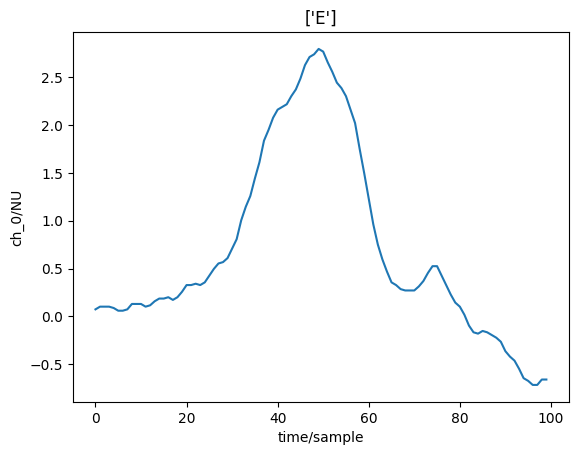

In [47]:
wfdb.plot.plot_items(train_signals[34570], title=train_labels[34570])

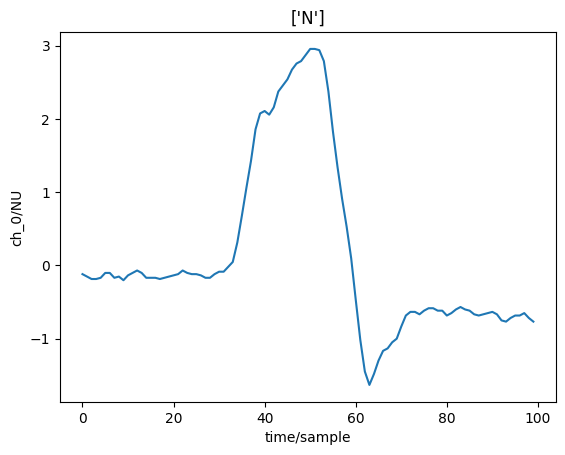

In [48]:
wfdb.plot.plot_items(train_signals[4362], title=train_labels[4362])

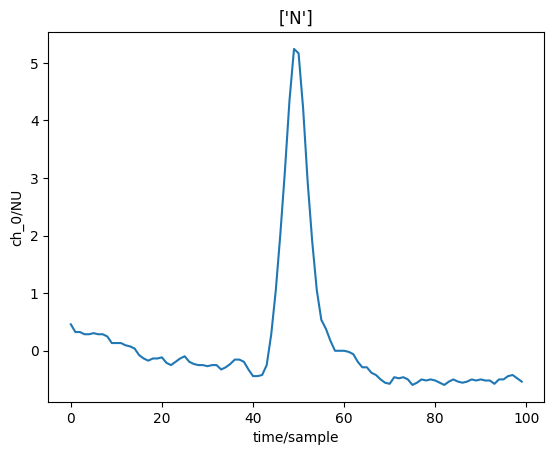

In [13]:
wfdb.plot.plot_items(train_signals[0], title=train_labels[0])

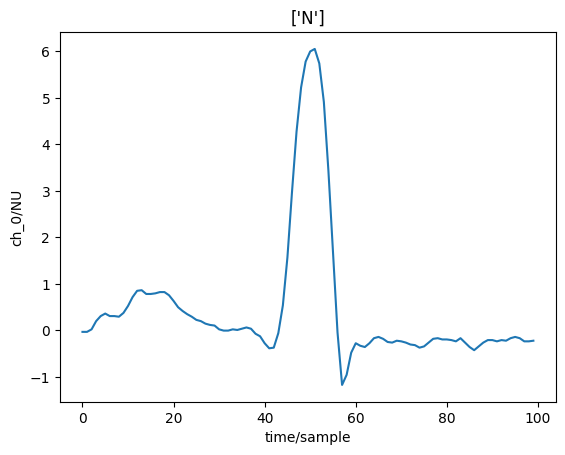

In [49]:
wfdb.plot.plot_items(train_signals[1967], title=train_labels[1967])

In [15]:
# Generator

In [16]:
def generator(X, y, batch_size):
    num_batches = len(X)//batch_size
    while True:
        np.random.seed(100)
        shuffle_sequence = np.random.permutation(len(X))
        X = X[shuffle_sequence]
        y = y[shuffle_sequence]
        
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,100,1))
            batch_labels = np.zeros((batch_size,4))
        
            for folder in range(batch_size):
                batch_data[folder,:,:] = X[folder + (batch*batch_size),:,:]
                batch_labels[folder,:] = y[folder + (batch*batch_size),:]
            yield batch_data.reshape(batch_size,1,100,1), batch_labels.reshape(batch_size,4)
            
            
        if (len(X)%batch_size != 0):
            batch_size = len(X) % batch_size
            
            batch_data = np.zeros((batch_size,100,1))
            batch_labels = np.zeros((batch_size,4))
        
            for folder in range(batch_size):
                batch_data[folder,:,:] = X[folder + (num_batches*batch_size),:,:]
                batch_labels[folder,:] = y[folder + (num_batches*batch_size),:]
            yield batch_data.reshape(batch_size,1,100,1), batch_labels.reshape(batch_size,4)

In [17]:
print('Shape of train data:', train_signals.shape)
print('Shape of train labels:', train_labels_encoded.shape)
print('Shape of validation data:', validation_signals.shape)
print('Shape of validation labels:', validation_labels_encoded.shape)
print('Shape of test data:', test_signals.shape)
print('Shape of test labels:', test_labels_encoded.shape)

Shape of train data: (102016, 100, 1)
Shape of train labels: (102016, 4)
Shape of validation data: (76214, 100, 1)
Shape of validation labels: (76214, 4)
Shape of test data: (23186, 100, 1)
Shape of test labels: (23186, 4)


In [18]:
batch_size = 2048
train_generator = generator(train_signals, train_labels_encoded, batch_size)
val_generator = generator(validation_signals, validation_labels_encoded, batch_size)

In [20]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Flatten, TimeDistributed, BatchNormalization, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
model = Sequential()

model.add(TimeDistributed(Conv1D(32, 5, activation='elu'), input_shape=(None, 100, 1)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))

model.add(TimeDistributed(Conv1D(32, 5, activation='elu'), input_shape=(None, 100, 1)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))


model.add(TimeDistributed(Conv1D(64, 4, activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))

model.add(TimeDistributed(Conv1D(64, 4, activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))


model.add(TimeDistributed(Conv1D(128, 3, activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))

model.add(TimeDistributed(Conv1D(128, 3, activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))


model.add(TimeDistributed(Conv1D(256, 2, activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))

model.add(TimeDistributed(Conv1D(256, 2, activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(8, strides=1)))


# extract features and dropout 
model.add(TimeDistributed(Flatten()))

model.add(TimeDistributed(Dense(256, activation='elu')))


# input to LSTM
model.add(LSTM(256, return_sequences=False, dropout=0.5))


# classifier with sigmoid activation for multilabel
model.add(Dense(4, activation='softmax'))

In [21]:
from keras import optimizers
optimizer = optimizers.Adam()
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["categorical_accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 96, 32)        │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, None, 96, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, None, 89, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, None, 85, 32)        │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, None, 85, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, None, 78, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, None, 75, 64)        │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, None, 75, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, None, 68, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, None, 65, 64)        │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, None, 65, 64)        │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, None, 58, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, None, 56, 128)       │          24,704 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, None, 56, 128)       │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, None, 49, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, None, 47, 128)       │          49,280 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, None, 47, 128)       │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, None, 40, 128)       │              

 Total params: 2,404,452 (9.17 MB)

 Trainable params: 2,402,532 (9.16 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [22]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_signals)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(validation_signals)
print('# validation sequences =', num_val_sequences)
num_epochs = 15# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 102016
# validation sequences = 76214
# epochs = 15


In [23]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [26]:
import os
import datetime
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

curr_dt_time = datetime.datetime.now()

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.makedirs(model_name)

# Change the file extension from .h5 to .weights.h5
filepath = model_name + 'model-{epoch:05d}-{loss:.3f}-{categorical_accuracy:.3f}-{val_loss:.3f}-{val_categorical_accuracy:.3f}.weights.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [29]:
history = model.fit(x=train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, shuffle=True, initial_epoch=0)
# Removed 'workers=1' and 'use_multiprocessing=False'

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.8728 - loss: 0.3367
Epoch 1: val_loss improved from inf to 1.38682, saving model to model_init_2025-07-1917_53_15.466582/model-00001-0.189-0.939-1.387-0.463.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - categorical_accuracy: 0.8741 - loss: 0.3338 - val_categorical_accuracy: 0.4631 - val_loss: 1.3868 - learning_rate: 0.0010
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9725 - loss: 0.0923
Epoch 2: val_loss did not improve from 1.38682
50/50 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - categorical_accuracy: 0.9725 - loss: 0.0922 - val_categorical_accuracy: 0.3806 - val_loss: 1.6637 - learning_rate: 0.0010
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - categorical_accuracy: 0.9769 - loss: 0.0804
Epoch 3: val_loss improved from 1.38682 to 0.58139, saving model to model_init_2025-07-1917_53_15.466582/model-00003-0.088-0.974-0.581-0.763.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/ste

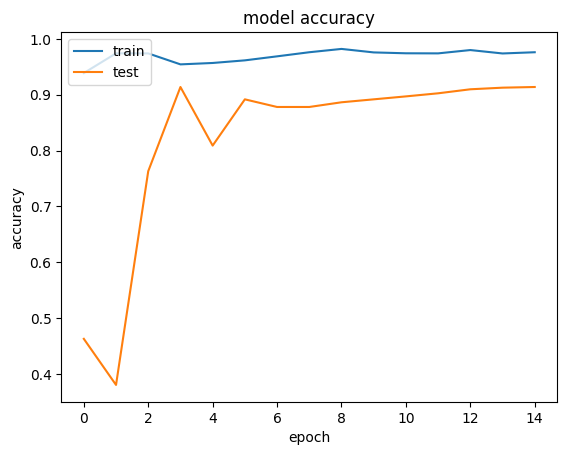

In [30]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

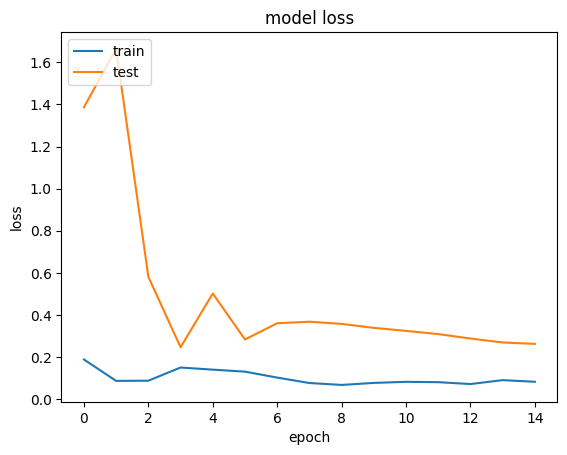

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model Evaluation

In [32]:
# Save the model
model.save('model-00006-0.159-0.952-0.002-0.961.h5')

In [33]:
from keras.models import load_model

# Load the model for evaluation
test_model = load_model('model-00006-0.159-0.952-0.002-0.961.h5')

In [34]:
# Reshape the test data for prediction
test_signals_reshaped = test_signals.reshape(test_signals.shape[0], -1, test_signals.shape[1], test_signals.shape[2])

In [35]:
# Predict the test data
test_results = test_model.predict(test_signals_reshaped[:,:,:,:])
test_predicted = np.argmax(test_results, axis=1)

725/725 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step


In [36]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(test_labels_numerical, test_predicted)
print(confusion_matrix)

[[    0    23     3]
 [   17 19642   179]
 [    4  1262  2056]]


In [37]:
# Classification_report
print(metrics.classification_report(test_labels_numerical, test_predicted))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        26
           2       0.94      0.99      0.96     19838
           3       0.92      0.62      0.74      3322

    accuracy                           0.94     23186
   macro avg       0.62      0.54      0.57     23186
weighted avg       0.93      0.94      0.93     23186



Created a model with 94% accuracy for arrhythmia detection using 1D ECG signals.